## This dataset contains app reviews from google play store. The [data](https://www.kaggle.com/lava18/google-play-store-apps) can be found here.  Only the google user review datset was considered to carry out text classification

## Import the necessary libraries

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.text import *

## Preparing the data

In [3]:
path = "/home/CRC/shjahagirdar/.fastai/data/googleReviews/"

It only contains one csv file, let's have a look at it.

In [4]:
df = pd.read_csv(path+"googleplaystore_user_reviews_filtered.csv")
df.head()

,Sentiment,Translated_Review
0,Neutral,81759
1,Positive,- GIFs seem able uploaded shared albums - It w...
2,Positive,"- really love , u also make a lot new friends ..."
3,Negative,!!!Dont waste time! Failed Samsung flagship ph...
4,Neutral,"""...Future Follow updated follow""..."


In [5]:
df.rename(columns={'Translated_Review':"text","Sentiment":"label"},inplace=True)

In [6]:
df.head()

,label,text
0,Neutral,81759
1,Positive,- GIFs seem able uploaded shared albums - It w...
2,Positive,"- really love , u also make a lot new friends ..."
3,Negative,!!!Dont waste time! Failed Samsung flagship ph...
4,Neutral,"""...Future Follow updated follow""..."


In [7]:
df['text'][1]

"- GIFs seem able uploaded shared albums - It would great pictures 'Portrait Mode' uploaded shared album format 2 photos normally shown together users gallery - It would useful user could set geo locations removed sharing full image message e.g. Facebook Messenger like sharing via link"

####  This one line of code carries out two important steps needed to feed the data into the deep learning model, Tokenization and  Numericalization. Tokenization is carried out to split the raw sentences into words or token. This takes care of puntuations and cleans part of certains texts that may contain html as well

In [8]:
data_lm = TextLMDataBunch.from_csv(path, 'googleplaystore_user_reviews_filtered.csv')

In [9]:
data_lm.save()

In [10]:
data = load_data(path)

In [11]:
data.show_batch()

idx,text
0,xxbos xxmaj overall worked i intended do . i wanted something estimate calories guide food choices . i able recognize much eating i really doing . xxmaj that said pain retype alot combination meals . i wish could store full meals . xxmaj other maybe better beginning wieght loss journey great . xxbos xxmaj can please quit auto refresh irritating . i know bots giving five stars keeps changing things
1,"thanks xxbos i love everything game ! xxmaj except audio through xxmaj bluetooth headphones terrible . xxmaj it gets echoes , choppy really scratchy . xxmaj plz fix that ! ! xxmaj great game otherwise feels like console quality . xxbos xxmaj thanks i messages end week i help way help xxmaj kdosid$8(37_ud83(_8""838_8""iziwixiiaiiwisosidixkskd i go store get rest feel better soon xxbos xxmaj hateful cause can not get xxbos i"
2,for .. xxmaj thanks friend recommended me .. month searching right record finances .. keep using long long time .. xxbos xxmaj well xxmaj done superb xxbos xxmaj it 's helpful . i m hoping i pass reviews . xxbos xxmaj when play game n suddenly hv xxunk missed call game loss connection .. n xxunk connecting ... xxmaj that 's main problem .. xxmaj otherwise game xxmaj good ..
3,xxbos xxmaj my original rating 01 / 2015 5 xxmaj stars still holding strong ! xxmaj my cell phone co hard reset i lost games . i 've started xxmaj candy xxmaj crush love updates made . xxmaj they make much fun ! i 'm still playing much higher level tablet i change back forth lives recharging . xxbos xxmaj good recipes still have n't made yet . xxbos i
4,", shows enjoyeble watch . xxmaj lately though fix buffering issue i would rate higher . xxmaj do n't like watching 30 secs show buffering hits wait longer show plays . xxmaj ca n't believe i pay premium get kinda problem . xxmaj give days fixed xxup unistalling . xxmaj cancelling sub xxbos xxmaj been playing two years swings ruin game . xxmaj if opponents random would 5 stars ."


In [12]:
data.vocab.itos[:10]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 '.']

And if we look at what a what's in our datasets, we'll see the tokenized text as a representation:

In [13]:
data.train_ds[0][0]

Text xxbos xxmaj very good

But the underlying data is all numbers

In [14]:
data.train_ds[0][0].data[:10]

array([ 2,  5, 66, 18])

## Language model

In [15]:
path = "/home/CRC/shjahagirdar/.fastai/data/googleReviews/"

In [16]:
path

'/home/CRC/shjahagirdar/.fastai/data/googleReviews/'

### For our reviews we first carry out language modelling, where in for all thje given reviews we take each review and try to predict the next word of a given rivew. This enables the model to learn the english behing the reviews and perform better at classification. For carrying out language modelling, a pretrained model wikitext103 has been used.

In [17]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

#### Helps to find the most optimal learning rate at which the loss is reducing 

In [18]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


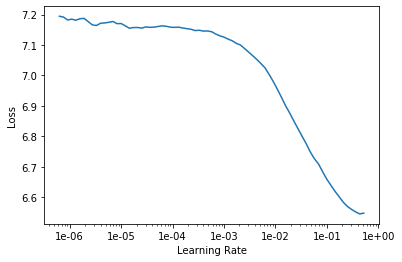

In [19]:
learn.recorder.plot(skip_end=15)

#### Fit the model freezing all the layers of the neural net except the last layer. This is done to modify the weights of only the last layer which are not as good as the previous layers

In [20]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.144135,4.872525,0.228774,00:18


In [21]:
learn.save('fit_head')

In [25]:
learn.load('fit_head');

#### To complete the fine-tuning, we can then unfeeze and launch a new training.

In [26]:
learn.unfreeze()

In [27]:
learn.fit_one_cycle(3, 1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.679186,4.555197,0.252988,00:19
1,4.177270,4.199690,0.295586,00:18
2,3.374664,4.047150,0.328110,00:18


#### Our language model performs well, it predicts the next word of a review 33% of the time correctly

In [28]:
learn.save('fine_tuned')

How good is our model? Well let's try to see what it predicts after a few given words.

In [29]:
learn.load('fine_tuned');

#### Some of the predictions from our model, for instances starting the sentence from i love this app and i hate this app produces the following results

In [63]:
TEXT = "I love this app because"
N_WORDS = 20
N_SENTENCES = 1

In [64]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I love this app because i found it . i love it ! ! xxbos This best free watching list i 've ever used


In [35]:
TEXT = "I hate this app because"
N_WORDS = 10
N_SENTENCES = 1

In [36]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I hate this app because i can not use it for real money .


In [66]:
learn.save_encoder('fine_tuned_enc')

## Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

In [74]:
data_clas = (TextClasDataBunch.from_csv(path,"googleplaystore_user_reviews_filtered.csv",vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_rand_pct()
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_df(cols=0)
             #label them all with their folders
             .databunch(bs=16))

data_clas.save('data_clas.pkl')

In [75]:
data_clas = load_data(path, 'data_clas.pkl', bs=16)

In [76]:
data_clas.show_batch()

text,target
xxbos [ 2 5 xxunk 18 xxunk xxunk xxunk xxunk xxunk xxrep 4 1 9 5 xxunk 10 109 xxunk xxunk 9 5 xxunk 90 xxunk 80 xxunk xxunk xxunk xxunk 28 12 28 12 5 xxunk xxunk xxunk xxrep 4 1 xxunk xxunk xxunk xxunk 12 12 12 5 xxunk xxunk xxunk xxunk xxunk 12 12 12 ],Negative
xxbos [ 2 10 xxunk xxunk xxunk 10 10 72 xxunk 10 36 xxunk 9 5 13 xxunk 21 xxunk xxunk 5 xxunk 56 9 xxunk 5 xxunk 24 xxunk xxrep 4 4 24 xxunk xxunk 9 5 164 10 158 330 xxunk 6 xxunk 6 xxunk 28 5 xxunk 5 xxunk 40 9 5 xxunk ],Positive
xxbos [ 2 5 xxunk xxunk xxunk xxunk 11 xxunk 6 xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk xxunk 85 xxunk 11 10 xxunk xxunk xxunk xxunk 50 85 xxunk xxunk 9 5 xxunk 6 xxunk 11 0 xxunk xxunk 37 xxunk xxunk 11 xxunk xxunk 111 11 xxunk 18 9 ],Positive
xxbos [ 2 5 705 10 16 5 xxunk 11 10 xxunk xxunk 20 9 5 15 xxunk xxunk 11 xxunk xxunk 0 xxunk 109 xxunk xxunk xxunk xxunk 9 5 15 xxunk 0 xxunk xxunk xxunk 11 xxunk xxunk xxunk xxunk xxunk xxunk xxunk 20 11 xxunk xxunk 9 5 xxunk xxunk 9 ],Negative
xxbos [ 2 10 xxunk 16 2013 xxunk xxunk xxunk 9 5 42 27 16 xxunk 122 9 5 xxunk 27 xxunk xxunk xxunk 85 xxunk xxunk xxunk 9 5 xxunk xxunk xxunk 6 xxrep 4 1 7 xxunk xxunk 10 36 xxunk xxunk xxunk 35 19 9 5 xxunk xxunk xxunk xxunk 9 ],Negative


We can then create a model to classify those reviews and load the encoder we saved before.

In [77]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (23953 items)
x: TextList
xxbos [ 2 5 xxunk ],xxbos [ 2 5 xxunk xxunk 5 xxunk xxunk xxunk xxunk xxunk ],xxbos [ 2 5 xxunk xxunk ],xxbos [ 2 10 xxunk xxunk ... 17 xxunk xxunk 25 ],xxbos [ 2 5 13 365 xxunk xxunk 9 5 110 xxunk xxunk xxunk 10 101 xxunk xxunk 9 10 5 400 xxunk 100 11 xxunk xxunk xxunk xxunk 89 xxunk xxunk 9 ]
y: CategoryList
Positive,Positive,Positive,Negative,Positive
Path: /home/CRC/shjahagirdar/.fastai/data/googleReviews;

Valid: LabelList (5988 items)
x: TextList
xxbos [ 2 5 22 xxunk 9 5 xxunk 10 xxunk 10 23 xxunk 9 5 32 xxunk xxunk xxunk 9 5 13 xxunk xxunk xxunk xxunk xxunk 10 xxunk xxunk 95 209 xxunk 9 5 13 17 62 10 xxunk 64 41 65 xxunk 0 9 5 xxunk xxunk 9 ],xxbos [ 2 5 87 5 xxunk 41 87 xxunk 16 42 xxunk xxunk xxunk 0 124 xxunk 0 41 xxunk 9 ],xxbos [ 2 5 300 xxunk ... 39 xxunk xxunk 9 ],xxbos [ 2 5 xxunk 14 ],xxbos [ 2 5 66 18 46 xxunk 51 xxunk 9 ]
y: CategoryList
Positive,Positive,Positive,Negative,Positive
Path: /h

In [78]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


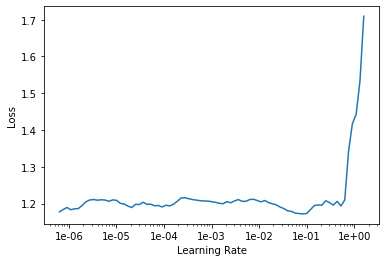

In [79]:
learn.recorder.plot()

In [81]:
learn.fit_one_cycle(3, 1e-4, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.922382,0.840882,0.627421,00:34
1,0.863108,0.796748,0.644456,00:32
2,0.868120,0.795845,0.648965,00:35


In [82]:
learn.save('first')

In [83]:
learn.load('first');

In [84]:
learn.freeze_to(-2)
learn.fit_one_cycle(3, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.759713,0.677255,0.678023,00:36
1,0.707803,0.643989,0.687041,00:33
2,0.716377,0.623596,0.698898,00:35


In [85]:
learn.save('second')

In [86]:
learn.load('second');

In [87]:
learn.freeze_to(-3)
learn.fit_one_cycle(6, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.682040,0.623233,0.699399,00:36
1,0.673261,0.618408,0.700234,00:35
2,0.654026,0.754052,0.713093,00:34
3,0.626124,0.615530,0.709419,00:35
4,0.629434,0.611352,0.716433,00:38
5,0.591616,0.602742,0.716767,00:35


In [88]:
learn.save('third')

In [89]:
learn.load('third');

In [90]:
learn.unfreeze()
learn.fit_one_cycle(6, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.618699,0.658009,0.717602,00:36
1,0.627595,0.654618,0.719773,00:38
2,0.603646,0.597524,0.716266,00:35
3,0.624592,0.617437,0.719439,00:39
4,0.616772,0.613739,0.721777,00:37
5,0.604975,0.600967,0.721109,00:41


In [91]:
learn.fit_one_cycle(6, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.608305,0.591432,0.731296,00:39
1,0.616206,0.661603,0.728791,00:37
2,0.610995,0.647738,0.731129,00:36
3,0.616710,0.647786,0.727622,00:37
4,0.615759,0.674068,0.730461,00:38
5,0.595071,0.585720,0.729292,00:38


In [92]:
learn.predict("I really loved that app, it was awesome!")

(Category Positive, tensor(2), tensor([1.3789e-01, 4.8094e-06, 8.6211e-01]))